In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr" #"all"

In [2]:
import gc
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import dscribe
import ase

bond_types = ['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN']
pickles = [i for i in os.listdir('data') if ".pkl" in i]
#dfs = {i[:-4] : pd.read_pickle('data/'+i) for i in pickles}
#print ("\t".join(dfs.keys()))
print (pickles)
more_pickles = [i for i in os.listdir('data/additional') if ".pkl" in i]
print (more_pickles)
len_train = 4658147
def read_pkl(fname):
    return pd.read_pickle('data/' + fname + '.pkl')

['traintestadj.pkl', 'distances.pkl', 'magnetic_shielding_tensors.pkl', 'traintestpathfixed.pkl', 'df_graph_fixed.pkl', 'test.pkl', 'traintest.pkl', 'dipole_moments.pkl', 'structures_reindexed.pkl', 'train_molecule_names.pkl', 'lengthes_4.pkl', 'train_contrib.pkl', 'df_graph.pkl', 'traintestpathmulti.pkl', 'traintestall.pkl', 'train.pkl', 'potential_energy.pkl', 'struc_and_dist.pkl', 'structures.pkl', 'strucs_some_feat.pkl', 'traintestpath.pkl', 'test_molecule_names.pkl', 'dist_df.pkl', 'mulliken_charges.pkl', 'traintestadjfixed.pkl']
['aseAtoms.pkl', 'ASCF_features.pkl', 'ASCF_features1208.pkl', 'strucs_nn_features.pkl', 'nn_atoms_mult_total.pkl']


In [3]:
import torch
from importlib import reload
from torch import nn
from torch.functional import F
from sklearn.model_selection import train_test_split
from torch.optim import Adam, SGD
torch.manual_seed(999)
import tqdm

In [4]:
gc.collect()

0

In [16]:
device = torch.device('cuda:0')

In [6]:
features = pd.read_pickle('features/nn_features1708.pkl')
df_graph = pd.read_pickle('data/df_graph_fixed.pkl')
strucs = pd.read_pickle('data/struc_and_dist.pkl')
strucs_nn_features = pd.read_pickle('data/additional/strucs_nn_features.pkl')
#molecule_names = pd.read_pickle('data/train_molecule_names.pkl').unique()
trantest = pd.read_pickle('cc/traintestnnindexed.pkl')
weights = pd.read_pickle('cc/weights.pkl')
coupling_means = pd.read_pickle('cc/coupling_constant_means.pkl')
coupling_stds = pd.read_pickle('cc/coupling_constant_stds.pkl')

In [14]:
train_mols, val_mols = train_test_split(molecule_names, test_size=0.1, random_state=42)

In [7]:
test_molecule_names = pd.read_pickle('data/test_molecule_names.pkl').unique()

In [8]:
val_mols = test_molecule_names

In [9]:
val_mols

array(['dsgdb9nsd_000004', 'dsgdb9nsd_000015', 'dsgdb9nsd_000016', ...,
       'dsgdb9nsd_133872', 'dsgdb9nsd_133883', 'dsgdb9nsd_133885'],
      dtype=object)

In [9]:
import MyNet2 as MyNet
#from MyNet import expand_features, expand_matrix, generator, myNet
reload (MyNet)

<module 'MyNet2' from '/data/nikita/Molecules/MyNet2.py'>

In [17]:
#import MyNet2 as MyNet
#from MyNet import expand_features, expand_matrix, generator, myNet
#reload (MyNet)

h_h = 64
#gen = MyNet.generator(train_mols, batch_size=128)
#valgen = MyNet.generator(val_mols, batch_size=128)

net = MyNet.myNet(65,18, h_h=h_h, h_g=24, nCells=6)
net.to(device)
poolnet = {2:  MyNet.poolNet(h_in=2*h_h + 29, h_h=h_h, nHidLayers=2).to(device),
          3:   MyNet.poolNet(h_in=3*h_h + 58, h_h=h_h, nHidLayers=2).to(device),
          4:   MyNet.poolNet(h_in=4*h_h + 88, h_h=h_h, nHidLayers=2).to(device)}

optimizer = Adam(list(net.parameters()) + list(poolnet[2].parameters())
                 + list(poolnet[3].parameters()) + list(poolnet[4].parameters()), lr=0.003)  

In [13]:
checkpoint = torch.load('/home/ikari/savednn/2608-2/epoch-257.pt')

In [18]:
net.load_state_dict(checkpoint['net_state_dict'])
poolnet[2].load_state_dict(checkpoint['poolnet_2_state_dict'])
poolnet[3].load_state_dict(checkpoint['poolnet_3_state_dict'])
poolnet[4].load_state_dict(checkpoint['poolnet_4_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [20]:
torch.save({
            'epoch': -1,
            'net_state_dict': net.state_dict(),
            'poolnet_2_state_dict' : poolnet[2].state_dict(),
            'poolnet_3_state_dict' : poolnet[3].state_dict(),
            'poolnet_4_state_dict' : poolnet[4].state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            #'loss': loss,
            }, '/home/ikari/savednn/epoch-minus1.pt')

In [12]:
n_epochs = 1
train_loss = []
val_loss = []
batch_size = 128

In [24]:
trantest.tail()

atom_index_0  atom_index_1  type  \
molecule_name    id                                          
dsgdb9nsd_133885 7163684            15             3  2JHC   
                 7163685            15             4  2JHC   
                 7163686            15             6  3JHC   
                 7163687            15             7  2JHC   
                 7163688            15             8  1JHC   

                          scalar_coupling_constant           path  \
molecule_name    id                                                 
dsgdb9nsd_133885 7163684                       NaN     [15, 8, 3]   
                 7163685                       NaN     [15, 8, 4]   
                 7163686                       NaN  [15, 8, 7, 6]   
                 7163687                       NaN     [15, 8, 7]   
                 7163688                       NaN        [15, 8]   

                                pathmulti  
molecule_name    id                        
dsgdb9nsd_133885 7163684     [[15, 8, 3]]  
                 7163685     [[15, 8, 4]]  
                 7163686  [[15, 8, 7, 6]]  
                 7163687     [[15, 8, 7]]  
                 7163688        [[15, 8]]

In [20]:
real_answ = pd.DataFrame(data=trantest[['type', 'scalar_coupling_constant']].values,
                         index = trantest.index.get_level_values(1),
                         columns = ['type', 'scalar_coupling_constant'])
real_answ['predicted_answ'] = 0.
real_answ['is_validation'] = False

In [24]:
real_answ.head()

,type,scalar_coupling_constant,predicted_answ,is_validation
id,,,,
0,1JHC,-0.556351,0.0,False
1,2JHH,-0.243842,0.0,False
2,2JHH,-0.243289,0.0,False
3,2JHH,-0.243163,0.0,False
4,1JHC,-0.556362,0.0,False


In [19]:
import time

In [35]:
#torch.cuda.empty_cache()

In [22]:
for epoch in range(1):
    gc.collect()
    print ("epoch = {}".format(epoch))
    for status in ['validate']:#['train', 'validate']:
        if (status == 'train'):
            gen = MyNet.generator(train_mols, batch_size=batch_size, seed=epoch)
            net.eval()
            poolnet[2].eval()
            poolnet[3].eval()
            poolnet[4].eval()
        else:
            gen = MyNet.generator(val_mols, batch_size=batch_size, seed=123456-epoch)
            net.eval()
            poolnet[2].eval()
            poolnet[3].eval()
            poolnet[4].eval()
            
        loss_per_batch = []
        ii = 0
        for i in tqdm.tqdm(gen, miniters=5):
            ii+=1
            if (ii % 25) == 0:
                gc.collect()
            #time_now = time.time()
            #strucs_loc_i = strucs.loc[i]
            df_graph_loc_i = df_graph.loc[i]
            features_loc_i = features.loc[i]
            trantest_loc_i = trantest.loc[i]
            #print ("time to loc_i {}".format(time.time() - time_now))
            #time_now = time.time()
            A = df_graph_loc_i.AdjMatrix
            A = np.stack(A.apply(MyNet.expand_matrix).values)
            e_features = []

            for col in ['EdgeLen', 'Multiplicity']:
                E = df_graph_loc_i[col]
                E = np.stack(E.apply(MyNet.expand_matrix).values)
                e_features.append(E)

            E = df_graph_loc_i['EdgesOneHot']
            e_3dfeatures = np.stack(E.apply(MyNet.expand_matrix, args=(False,)).values)

            e_features = np.stack(e_features,axis=3)
            e_features = np.concatenate((e_features, e_3dfeatures),axis=3)
            fcounts = np.unique(features_loc_i.index.get_level_values(0), return_counts=True)[1]
            ff = MyNet.expand_features(features_loc_i.values, fcounts)
            ss = MyNet.expand_features(strucs_nn_features.loc[i].values, fcounts)
            ff = np.concatenate((ff,ss),axis=2)

            xyz = MyNet.expand_features(strucs[['x','y','z']].loc[i].values, fcounts)

            xyz = torch.FloatTensor(xyz).to(device)
            A = torch.FloatTensor(A).to(device)
            e_features = torch.FloatTensor(e_features).to(device)
            ff = torch.FloatTensor(ff).to(device)


            tt = trantest_loc_i.path
            ytrue = trantest_loc_i.scalar_coupling_constant
            batch_type = trantest_loc_i.type
            batch_weights = trantest_loc_i.type.map(weights)
            #print ("time to prepare data {}".format(time.time() - time_now))
            #time_now = time.time()
            
            output = net(A, ff, e_features)
            #print ("time to forward first nn {}".format(time.time() - time_now))
            #time_now = time.time()

            #print('a')
            mol_to_ind = {mol:j for j,mol in enumerate(i)}
            loss = torch.FloatTensor([0.]).to(device).squeeze()
            for LLen in [2,3,4]:
                tt2 = tt[tt.apply(lambda x: len(x)) == LLen]
                if (tt2.shape[0] == 0):
                    continue
                tensor_weights = torch.FloatTensor(batch_weights[tt2.index].values).view(-1,1).to(device)
                tensor_ytrue = torch.FloatTensor(ytrue[tt2.index].values).view(-1,1).to(device)
                list_of_indices = {}
                tmptensors = []
                #print('b')
                for j in range(LLen):
                    list_of_indices[j] = torch.LongTensor([[mol_to_ind[a[0]] for a in tt2.index],
                                                            [pathh[j] for pathh in tt2]]
                                                            ).to(device)
                    #print('c')
                    tmptensors.append(output[list_of_indices[j][0], list_of_indices[j][1]])
                    if (j == 0):
                        tmptensors.append(ff[list_of_indices[j][0], list_of_indices[j][1]][:,3:4]) #for first Hydrogen - always the same
                    else:
                        tmptensors.append(ff[list_of_indices[j][0], list_of_indices[j][1]][:,:9])
                    #print('d')
                for j in range(LLen):
                    for k in range(j + 1, LLen):
                        deltaR = torch.pow(torch.pow(xyz[list_of_indices[j][0], list_of_indices[j][1]] 
                                                     - xyz[list_of_indices[k][0], list_of_indices[k][1]], 2).sum(dim = -1, keepdim=True), 0.5)
                        tmptensors.append(deltaR)
                for j in range(LLen - 1):
                    k = j + 1
                    tmptensors.append(e_features[list_of_indices[j][0],list_of_indices[j][1], list_of_indices[k][1]])

                pulledtensor = torch.cat(tmptensors, dim=1).to(device)
                
                #print ("time to prepare queries {}".format(time.time() - time_now))
                #time_now = time.time()
                
                answ = poolnet[LLen](pulledtensor)                
                #loss = loss + torch.sum(torch.abs((answ - tensor_ytrue)*tensor_weights))
                thisind = tt2.index.get_level_values(1)
                real_answ.loc[thisind, 'predicted_answ'] = answ.squeeze().detach().to('cpu').numpy()
                if (status == 'validate'):
                    real_answ.loc[thisind, 'is_validation'] = True
                            
                #print ("time to forward run pooling head {}".format(time.time() - time_now))
                #time_now = time.time()
                
            if (status == 'train'):
                pass
                #loss.backward()
                #optimizer.step()
                #optimizer.zero_grad()
                                
                #print ("time to backprop {}".format(time.time() - time_now))
                #time_now = time.time()

            loss_per_batch.append(loss.item())
            
        if (status == 'train'):
            train_loss.append(np.mean(loss_per_batch))
        else:
            val_loss.append(np.mean(loss_per_batch))
        
    if len(train_loss):
        print("train loss epoch {} = {}".format(epoch, train_loss[-1]))
    if len(val_loss):
        print("val loss epoch {} = {}".format(epoch, val_loss[-1]))
    torch.save({
            'epoch': epoch,
            'net_state_dict': net.state_dict(),
            'poolnet_2_state_dict' : poolnet[2].state_dict(),
            'poolnet_3_state_dict' : poolnet[3].state_dict(),
            'poolnet_4_state_dict' : poolnet[4].state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            #'loss': loss,
            }, '/home/ikari/savednn/epoch-{}.pt'.format(epoch))
    

0it [00:00, ?it/s]

epoch = 0


358it [09:56,  1.67s/it]

val loss epoch 0 = 0.0


In [28]:
ff.shape

torch.Size([127, 29, 65])

In [27]:
e_features.shape

torch.Size([128, 29, 29, 18])

In [16]:
type(loss_per_batch[0])

float

In [ ]:
train_loss

In [ ]:
val_loss

In [ ]:
loss_per_batch

In [ ]:
pulledtensor.shape

In [ ]:
abc = torch.FloatTensor([0]).squeeze().to(device)

In [ ]:
'/home/ikari/savednn/epoch-{}.pt'.format(2)

In [ ]:
abc.backward()

In [ ]:
loss

In [ ]:
%%time
batch_weights[tt2.index]

In [25]:
tt2

NameError: name 'tt2' is not defined

In [33]:
real_answ.is_validation.unique()

array([False])

In [69]:
real_answ.head()

,type,scalar_coupling_constant,predicted_answ,is_validation
id,,,,
0,1JHC,-0.556351,-0.479095,False
1,2JHH,-0.243842,-0.337042,False
2,2JHH,-0.243289,-0.337105,False
3,2JHH,-0.243163,-0.337106,False
4,1JHC,-0.556362,-0.479089,False


In [75]:
coupling_means

type
1JHC    94.976151
1JHN    47.479885
2JHC    -0.270624
2JHH   -10.286605
2JHN     3.124754
3JHC     3.688470
3JHH     4.771023
3JHN     0.990730
Name: scalar_coupling_constant, dtype: float32

In [23]:
unscaled_answ = (real_answ.predicted_answ * real_answ.type.map(coupling_stds)) + real_answ.type.map(coupling_means)

In [4]:
#real_answ = pd.read_pickle('results/first_blin.pkl')

In [24]:
real_answ.to_pickle('results/2608-nn-result.pkl')

In [25]:
subm = unscaled_answ.iloc[4658147:]

In [26]:
subm = subm.to_frame()

In [27]:
subm.columns = ['scalar_coupling_constant']

In [28]:
subm.astype('float32').to_csv('results/2608-nn-result.csv')

In [29]:
subm.scalar_coupling_constant

id
4658147     19.286370
4658148    197.569269
4658149      3.616935
4658150    197.569269
4658151     19.286370
4658152     92.082437
4658153      2.736524
4658154     -7.454549
4658155     -9.642030
4658156     92.083732
4658157      2.743327
4658158     -9.642026
4658159     82.744617
4658160     12.128839
4658161      2.737471
4658162     92.082800
4658163     -7.454483
4658164     -9.642015
4658165      2.742379
4658166     92.083516
4658167     -9.641995
4658168     12.128827
4658169     82.744587
4658170    106.621162
4658171     -1.146580
4658172     -1.146093
4658173     -3.533242
4658174      4.043827
4658175      7.419607
4658176      7.419400
              ...    
7163659    113.554049
7163660      4.263464
7163661      2.149866
7163662      1.819719
7163663      0.914088
7163664      1.654030
7163665      3.820852
7163666      0.435443
7163667      3.471345
7163668    130.708991
7163669      5.485856
7163670      0.435441
7163671      3.471334
7163672      1.556812
7163673

In [5]:
trainvalansw = real_answ[real_answ.scalar_coupling_constant.notna()]

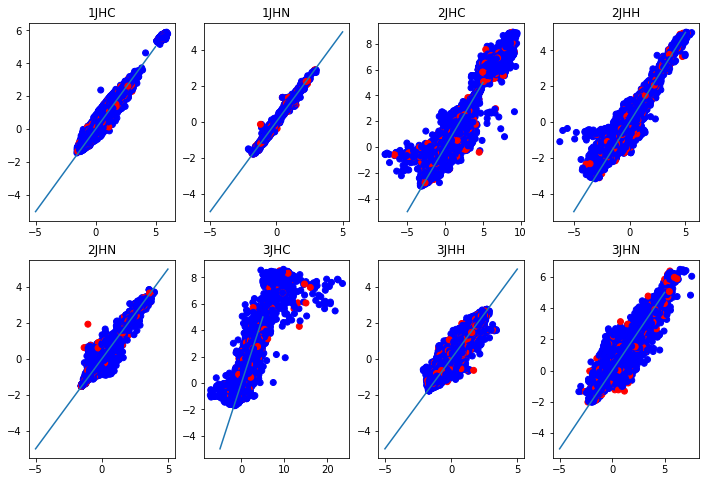

In [7]:
plt.figure(figsize=(12,8))
for i, btype in enumerate(bond_types):
    plt.subplot(2,4,i+1)
    plt.title(btype)
    subdf = trainvalansw.loc[real_answ.type == btype]
    plt.scatter(subdf.scalar_coupling_constant, 
                subdf.predicted_answ, c=subdf.is_validation.map({False: 'blue', True: 'red'}))
    plt.plot([-5,5], [-5,5])

In [47]:
real_answ

,type,scalar_coupling_constant,predicted_answ,is_validation
id,,,,
0,1JHC,-0.556351,-0.479095,False
1,2JHH,-0.243842,-0.337042,False
2,2JHH,-0.243289,-0.337105,False
3,2JHH,-0.243163,-0.337106,False
4,1JHC,-0.556362,-0.479089,False
5,2JHH,-0.243113,-0.337113,False
6,2JHH,-0.243289,-0.337118,False
7,1JHC,-0.556258,-0.479069,False
8,2JHH,-0.243163,-0.337239,False


,type,scalar_coupling_constant,predicted_answ,is_validation
id,,,,
0,1JHC,-0.556351,-0.479095,False
1,2JHH,-0.243842,-0.337042,False
2,2JHH,-0.243289,-0.337105,False
3,2JHH,-0.243163,-0.337106,False
4,1JHC,-0.556362,-0.479089,False
5,2JHH,-0.243113,-0.337113,False
6,2JHH,-0.243289,-0.337118,False
7,1JHC,-0.556258,-0.479069,False
8,2JHH,-0.243163,-0.337239,False


In [37]:
uniq = np.unique(strucs_nn_features.loc[i].index.get_level_values(0))

In [45]:
uniq

array(['dsgdb9nsd_000657', 'dsgdb9nsd_001310', 'dsgdb9nsd_002337',
       'dsgdb9nsd_002378', 'dsgdb9nsd_002663', 'dsgdb9nsd_004778',
       'dsgdb9nsd_006071', 'dsgdb9nsd_008782', 'dsgdb9nsd_012872',
       'dsgdb9nsd_014863', 'dsgdb9nsd_015147', 'dsgdb9nsd_017331',
       'dsgdb9nsd_019647', 'dsgdb9nsd_019823', 'dsgdb9nsd_020491',
       'dsgdb9nsd_020818', 'dsgdb9nsd_023343', 'dsgdb9nsd_024722',
       'dsgdb9nsd_026372', 'dsgdb9nsd_031172', 'dsgdb9nsd_031200',
       'dsgdb9nsd_031608', 'dsgdb9nsd_031858', 'dsgdb9nsd_034884',
       'dsgdb9nsd_035357', 'dsgdb9nsd_035695', 'dsgdb9nsd_035972',
       'dsgdb9nsd_036103', 'dsgdb9nsd_037518', 'dsgdb9nsd_039933',
       'dsgdb9nsd_040511', 'dsgdb9nsd_041418', 'dsgdb9nsd_043309',
       'dsgdb9nsd_044618', 'dsgdb9nsd_045432', 'dsgdb9nsd_050576',
       'dsgdb9nsd_051004', 'dsgdb9nsd_052624', 'dsgdb9nsd_053599',
       'dsgdb9nsd_055563', 'dsgdb9nsd_056873', 'dsgdb9nsd_058843',
       'dsgdb9nsd_058922', 'dsgdb9nsd_058969', 'dsgdb9nsd_0593

In [43]:
np.isin(i,uniq)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True]

In [46]:
np.unique(i)

array(['dsgdb9nsd_000657', 'dsgdb9nsd_001310', 'dsgdb9nsd_002337',
       'dsgdb9nsd_002378', 'dsgdb9nsd_002663', 'dsgdb9nsd_004778',
       'dsgdb9nsd_006071', 'dsgdb9nsd_008782', 'dsgdb9nsd_012872',
       'dsgdb9nsd_014863', 'dsgdb9nsd_015147', 'dsgdb9nsd_017331',
       'dsgdb9nsd_019647', 'dsgdb9nsd_019823', 'dsgdb9nsd_020491',
       'dsgdb9nsd_020818', 'dsgdb9nsd_023343', 'dsgdb9nsd_024722',
       'dsgdb9nsd_026372', 'dsgdb9nsd_031172', 'dsgdb9nsd_031200',
       'dsgdb9nsd_031608', 'dsgdb9nsd_031858', 'dsgdb9nsd_034884',
       'dsgdb9nsd_035357', 'dsgdb9nsd_035695', 'dsgdb9nsd_035972',
       'dsgdb9nsd_036103', 'dsgdb9nsd_037518', 'dsgdb9nsd_039933',
       'dsgdb9nsd_040511', 'dsgdb9nsd_041418', 'dsgdb9nsd_043309',
       'dsgdb9nsd_044618', 'dsgdb9nsd_045432', 'dsgdb9nsd_050576',
       'dsgdb9nsd_051004', 'dsgdb9nsd_052624', 'dsgdb9nsd_053599',
       'dsgdb9nsd_055563', 'dsgdb9nsd_056873', 'dsgdb9nsd_058843',
       'dsgdb9nsd_058922', 'dsgdb9nsd_058969', 'dsgdb9nsd_0593